You can view this notebook in Google Colab by clicking on [this link](https://colab.research.google.com/drive/1mCSfekW5lBlWu1s1RxC3Wo2F8d4_KTcw?usp=sharing). (Some of Latex expressions can't be displayed out of Google Colab)

# Multinomial logistic regression

We have implemented the case of a single class (binary: yes or no). To apply a ranking on several classes, we can train $L$ logistic regression models (where $L$ is the number of classes). In this case, our output (Y) must be encoded as 0 and 1. For a model $M_i$ of one class $C_i$, the output $Y$ must have 1 if $C_i$, 0 if another class. (One-to-rest classification)

Another approach (the one we will implement) is to encode the output using OneHot encoder. For $L$ classes and a given sample, we will have $L$ outputs (one having 1 and the others 0). For a dataset with $M$ samples, $N$ features and $L$ classes, we will have the following dimensions: 
- $X (M, N)$
- $Y (M, L)$
- $theta (L, N)$

This last approach is called maximum entropy (MaxEnt). It generalizes the logistic regression.

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

## Download the datasets

In [ ]:
! mkdir datasets
! wget -c "https://drive.google.com/uc?export=download&id=10qawaE4g-bjzg3Lmwpi_C51rSUk3B66H" -O datasets/iris.csv

--2021-11-26 21:21:19--  https://drive.google.com/uc?export=download&id=10qawaE4g-bjzg3Lmwpi_C51rSUk3B66H
Resolving drive.google.com (drive.google.com)... 142.250.65.78, 2607:f8b0:4004:832::200e
Connecting to drive.google.com (drive.google.com)|142.250.65.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/agl7ccjvrki5egirmmag1n0em5of6v4l/1637961675000/02428432253297012158/*/10qawaE4g-bjzg3Lmwpi_C51rSUk3B66H?e=download [following]
--2021-11-26 21:21:20--  https://doc-00-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/agl7ccjvrki5egirmmag1n0em5of6v4l/1637961675000/02428432253297012158/*/10qawaE4g-bjzg3Lmwpi_C51rSUk3B66H?e=download
Resolving doc-00-8o-docs.googleusercontent.com (doc-00-8o-docs.googleusercontent.com)... 142.250.73.225, 2607:f8b0:4004:82a::2001
Connecting to doc-00-8o-docs.googleusercontent.com (doc-00-8o-docs.go

## 1- Implementation 

### 1.1- Utils

In [ ]:
# Define functions that generate vectors or matrices
# These functions will be used to generate Thetas

def generer_zeros_2(nbr_x, nbr_y):
    return np.zeros((nbr_x, nbr_y))

def generer_uns_2(nbr_x, nbr_y):
    return np.ones((nbr_x, nbr_y))

def generer_aleatoire_2(nbr_x, nbr_y):
    return np.random.rand(nbr_x, nbr_y)
    
generer_zeros_2(2, 3), generer_uns_2(2, 3), generer_aleatoire_2(2, 3)

(array([[0., 0., 0.],
        [0., 0., 0.]]), array([[1., 1., 1.],
        [1., 1., 1.]]), array([[0.10781858, 0.46961851, 0.95129907],
        [0.71570314, 0.83818996, 0.81383021]]))

In [ ]:
X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

def preparer(X, norm=True, const=True, mean=None, std=None): 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

In [ ]:
X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

def normaliser(X, mean=None, std=None): 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    X_norm = (X - mean)/std
    return X_norm, mean, std

### 1.2- Linear combination
We combine the m features linearly. The only thing different is that z in this case is a matrix. (number_of_samples * number_of_classes) 

$$z=\theta_0+\sum\limits_{i=1}^{m} \theta_i x_i = X \theta^T $$

In [ ]:
# Implement the linear combination function 
def z_n(X, Theta): 
    Theta_t = np.matrix.transpose(Theta)
    return np.dot(X, Theta_t)

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

z_n(X_tn, Theta_tn)

array([[0. , 0. , 0. ],
       [0.5, 0.1, 0.6],
       [0.2, 0.3, 0. ],
       [0.7, 0.4, 0.6]])

### 1.2- Computation of probabilities

The combined values are transformed to probabilities using the softmax function. $L$ is the number of classes. $Z$ is a vector of linear comninations.

The softmax function generates weights where the sum of the columns always gives 1.0

$$softmax(Z)=\frac{e^Z}{\sum\limits_{k=1}^{L} e^{Z_k}}$$

In [ ]:
# Implement softmax function
def softmax(X):
    exp_X = np.exp(X)
    Sum = np.sum(exp_X, axis=1)
    return   exp_X/Sum[:, None]

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

softmax(z_n(X_tn, Theta_tn))

array([[0.33333333, 0.33333333, 0.33333333],
       [0.36029662, 0.24151404, 0.39818934],
       [0.34200877, 0.37797814, 0.28001309],
       [0.37797814, 0.28001309, 0.34200877]])

In [ ]:
def h_n(X, Theta_n, mean=None, std=None, const=False): 
    norm = (mean is not None) and (std is not None)
    X_pre, mean, std = preparer(X, norm, const, mean=mean, std=std)
    return softmax(z_n(X_pre, Theta_n))

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

h_n(X_tn, Theta_tn)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.36029662, 0.24151404, 0.39818934],
       [0.34200877, 0.37797814, 0.28001309],
       [0.37797814, 0.28001309, 0.34200877]])

### 1.3- Loss function 

- L: number of classes
- M: number of samples

$$ cout(h_\theta(x), y) = - \sum\limits_{c=1}^{L} y_c \log(h_{\theta,c}(x))$$

$$J(\theta) = \frac{1}{M} \sum\limits_{i=1}^{M} cout(h_\theta(x^{(i)}), y^{(i)})$$

In [ ]:
def J_n(H, Y): 
    return np.mean(-(Y*np.log(H)).sum(axis=1))

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

J_n(h_n(X_tn, Theta_tn), Y_tn)

1.1913194426181715

### 1.4- The gradients

$$\frac{\partial J(\theta)}{\theta_j} = \frac{1}{M} \sum\limits_{i=1}^{M} (h_\theta(x^{(i)}) - y^{(i)}) x_{ij} $$

In [ ]:
# The gradient function
def gradient_n(X, H, Y):
    return  np.dot((H - Y).T,X)/X.shape[0]

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

gradient_n(X_tn, h_n(X_tn, Theta_tn), Y_tn)

array([[-0.06543131, -0.07000327],
       [-0.11961822,  0.16449781],
       [ 0.18504953, -0.09449454]])

### 1.5- Training (gradient algorithm)

The coefficients are updated iteratively based on the gradient and a $\alpha$ learning step. Since this function has been implemented in the previous tutorial, it is given here, but in a more parameterizable way.

$$\theta_j = \theta_j - \alpha \frac{\partial J(\theta)}{\theta_j} $$

Our training function takes the following parameters: 
- X : matrix (characteristic X samples)
- Y : vector (or matrix) of results (samples X number_classes)
- norm : if we normalize X or name (default : True)
- const : if we add $\theta_0$ or not (default : True)
- nbr_iter : number of iterations before exit
- alpha : the learning rate
- eps : the stop test if the difference between the costs (current and previous) is lower than $\epsilon$ we stop the desent even if we did not finish all the iterations
- theta_func : the function which generates the $\theta$ (by default : zeros)
- h_func : the function that computes the probabilities (default : h_1)
- J_func : the cost function (default : J_1)
- grad_func : the function that computes the gradient (default : gradient_1)

In [ ]:
def entrainer_n(X, Y, norm=True, const=True, nbr_iter=200, alpha=1., eps=0.01, 
                theta_func=generer_zeros_2, h_func=h_n, J_func=J_n, grad_func=gradient_n):
    
    X_pre, mean, std = preparer(X, norm=norm, const=const)
    
    Theta = theta_func(Y.shape[1], X_pre.shape[1])
    
    couts = []
    couts.append(J_func(h_func(X_pre, Theta), Y))
    
    for i in range(nbr_iter):
        H = h_func(X_pre, Theta)
        Theta -= alpha * grad_func(X_pre, H, Y)
        couts.append(J_func(H, Y))
    
    return Theta, mean, std, couts

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

theta_n, mean_n, std_n, couts_n = entrainer_n(X_tn, Y_tn, const=False)

theta_n, mean_n, std_n, couts_n[-1]

(array([[ 5.55111512e-17, -2.77555756e-17],
        [ 2.32810552e+00, -2.32810552e+00],
        [-2.32810552e+00,  2.32810552e+00]]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 0.5541027976268512)

### 1.6- Prediction 

Given a threshold and probabilities, for each probability we return 1 if it exceeds or equals the threshold, 0 otherwise. 

In [ ]:
# H is a vector of probabilities 
def predire_n(H): 
    predic = []
    for row in H:
        predic.append( row >= np.amax(row))
    return np.array(predic).astype(int)

predire_n(h_n(X_tn, Theta_tn))

array([[1, 1, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

### 1.7- Grouping functions together 

In order to manage training and prediction, we group the functions you have implemented in a single class. The interest: 
- If we apply normalization during training, we must also apply it during prediction. Moreover, we have to use the same parameters (mean and standard deviation)
- We use the optimal thetas during the prediction


In [ ]:
class MaxEnt(object):
    
    def __init__(self, nbr_iter=100, alpha=1., theta_func=generer_zeros_2, norm=True, const=True): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.theta_func = theta_func
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y): 
        #encoder = OneHotEncoder(sparse=False)
        #self.yencoder = encoder.fit(Y)
        # Y = self.yencoder.transform(Y)
        self.Theta, self.mean, self.std, self.couts = entrainer_n(X, Y, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha, 
                                                                  theta_func=self.theta_func, 
                                                                  norm=self.norm, 
                                                                  const=self.const)
        
        
    # The prediction
    # if prob=True it returns a vector of probabilities
    # otherwise it returns a vector of 1 and 0
    def predire(self, X, prob=True, seuil=0.5):
        H = h_n(X, self.Theta, self.mean, self.std, self.const)
        if prob:
            return H
        return predire_n(H, seuil=seuil)

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

maxent = MaxEnt(const=False)
maxent.entrainer(X_tn, Y_tn)
maxent.predire(np.array([[2., -2.],[-1., 1.]]))

array([[1.80328326e-02, 9.81635901e-01, 3.31266462e-04],
       [1.80328326e-02, 3.31266462e-04, 9.81635901e-01]])

## 2- Application on a real example

We will use [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) to classify flowers in three classes, using 4 features. For simplification, we will use only 2 features: Petal Length (cm); Petal Width (cm). According to [This tutorial](https://teddykoker.com/2019/06/multi-class-classification-with-logistic-regression-in-python/) these 2 characteristics are sufficient.

Two solutions to analyze: 
- Train 3 binary logistic regression models
- Train 1 multinomial logistic regression model 

In [ ]:
iris = pd.read_csv("datasets/iris.csv")
iris = iris.sample(frac=1)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
71,6.1,2.8,4.0,1.3,Iris-versicolor
38,4.4,3.0,1.3,0.2,Iris-setosa
22,4.6,3.6,1.0,0.2,Iris-setosa
23,5.1,3.3,1.7,0.5,Iris-setosa
14,5.8,4.0,1.2,0.2,Iris-setosa


In [ ]:
if iris.shape[1] > 3:
    iris.drop(["sepal_length", "sepal_width"], axis = 1, inplace=True)
iris.head()

,petal_length,petal_width,class
71,4.0,1.3,Iris-versicolor
38,1.3,0.2,Iris-setosa
22,1.0,0.2,Iris-setosa
23,1.7,0.5,Iris-setosa
14,1.2,0.2,Iris-setosa


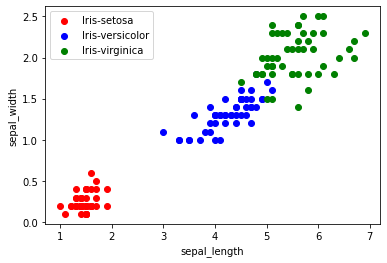

In [ ]:
# Feature extraction
X_iris = iris.iloc[:, :-1].values # First Column

Y_iris = iris.iloc[:,-1].values # Second Column

setosa = iris["class"] == "Iris-setosa"
versicolor = iris["class"] == "Iris-versicolor"
virginica = iris["class"] == "Iris-virginica"

plt.scatter(X_iris[setosa, 0], X_iris[setosa, 1], color="red", label="Iris-setosa")
plt.scatter(X_iris[versicolor, 0], X_iris[versicolor, 1], color="blue", label="Iris-versicolor")
plt.scatter(X_iris[virginica, 0], X_iris[virginica, 1], color="green", label="Iris-virginica")

plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend()
plt.show()

In [ ]:
# Randomization of the data to mark the 80% rows
# The same mask will be used for both solutions
iris_msk = np.random.rand(len(X_iris)) < 0.8 
X_iris_train = np.array(X_iris[iris_msk, :], dtype=np.float32)
X_iris_test = np.array(X_iris[~iris_msk, :], dtype=np.float32)

In [ ]:
iris["class"].value_counts()

Iris-versicolor    50
Iris-setosa        50
Iris-virginica     50
Name: class, dtype: int64

In [ ]:
# Encoding of classes 
Y_iris_setosa = (Y_iris == "Iris-setosa").astype(int)
Y_iris_versicolor = (Y_iris == "Iris-versicolor").astype(int)
Y_iris_virginica = (Y_iris == "Iris-virginica").astype(int)

Y_iris_setosa.sum(), Y_iris_versicolor.sum(), Y_iris_virginica.sum()

(50, 50, 50)

In [ ]:
# encode setosa by 1
Y_iris_setosa_test = np.array(Y_iris_setosa[~iris_msk], dtype=np.float32)
# encode versicolor by 2
Y_iris_versicolor_test = np.array(Y_iris_versicolor[~iris_msk], dtype=np.float32) * 2
# encode the output by 3
Y_iris_virginica_test = np.array(Y_iris_virginica[~iris_msk], dtype=np.float32) * 3
# merge the three vectors to have only one with the encoded classes
Y_iris_test = Y_iris_setosa_test + Y_iris_versicolor_test + Y_iris_virginica_test 
Y_iris_test

array([2., 1., 2., 1., 2., 3., 2., 1., 1., 3., 3., 3., 1., 2., 2., 2., 3.,
       1., 1., 2., 2., 2.], dtype=float32)

### 2.1- Train 3 binary logistic regression models


In [ ]:
def generer_zeros_1(nbr):
    return np.zeros(nbr)

def generer_uns_1(nbr):
    return np.ones(nbr)

def generer_aleatoire_1(nbr):
    return np.random.rand(nbr)

def z_1(X, Theta): 
    return np.dot(X, Theta)

def sigmoid(X):
    # Activation function used to render real values between 0 and 1 
    return  1/(1+np.exp(-X))

def h_1(X, Theta, mean=None, std=None, const=False): 
    norm = (mean is not None) and (std is not None)
    X_pre, mean, std = preparer(X, norm, const, mean=mean, std=std)
    return sigmoid(z_1(X_pre, Theta))

def J_1(H, Y): 
    ones = np.ones([1, Y.shape[0]])
    log_H = np.log(H)
    log_1_H = np.log(ones-H)
    return ((np.dot(-Y,log_H.T) - np.dot((ones - Y), log_1_H.T))/Y.shape[0])[0]

def gradient_1(X, H, Y):
    return (np.dot(H-Y,X))/X.shape[0]

def entrainer_1(X, Y, norm=True, const=True, nbr_iter=200, alpha=1., eps=0.01, 
                theta_func=generer_zeros_1, h_func=h_1, J_func=J_1, grad_func=gradient_1): 
    
    X_pre, mean, std = preparer(X, norm, const)
    Theta = theta_func(X_pre.shape[1])
    
    couts = []
    couts.append(J_func(h_func(X_pre, Theta), Y))
    
    for i in range(nbr_iter):
        H = h_func(X_pre, Theta)
        Theta -= alpha * grad_func(X_pre, H, Y)
        couts.append(J_func(H, Y))
    
    return Theta, mean, std, couts

def predire_1(H, seuil=0.5): 
    return (H >= seuil).astype(int)

class RegLogistique(object):
    
    def __init__(self, nbr_iter=100, alpha=1., theta_func=generer_zeros_1, norm=True, const=True): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.theta_func = theta_func
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y): 
        self.Theta, self.mean, self.std, self.couts = entrainer_1(X, Y, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha, 
                                                                  theta_func=self.theta_func, 
                                                                  norm=self.norm, 
                                                                  const=self.const)
        
    # The prediction
    # if prob=True it returns a vector of probabilities
    # otherwise it returns a vector of 1 and 0
    def predire(self, X, prob=True, seuil=0.5):
        H = h_1(X, self.Theta, self.mean, self.std, self.const)
        if prob:
            return H
        return predire_1(H, seuil=seuil)

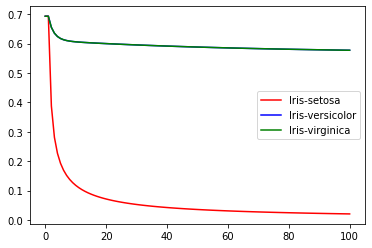

In [ ]:
#model 1
Y_iris_setosa_train = np.array(Y_iris_setosa[iris_msk], dtype=np.float32)
reg_iris_setosa = RegLogistique()
reg_iris_setosa.entrainer(X_iris_train, Y_iris_setosa_train)

#model 2
Y_iris_versicolor_train = np.array(Y_iris_versicolor[iris_msk], dtype=np.float32)
reg_iris_versicolor = RegLogistique()
reg_iris_versicolor.entrainer(X_iris_train, Y_iris_versicolor_train)

#model 3
Y_iris_virginica_train = np.array(Y_iris_virginica[iris_msk], dtype=np.float32)
reg_iris_virginica = RegLogistique()
reg_iris_virginica.entrainer(X_iris_train, Y_iris_versicolor_train)


# Display of the evolution of costs 
plt.plot(reg_iris_setosa.couts, color="red", label="Iris-setosa")
plt.plot(reg_iris_versicolor.couts, color="blue", label="Iris-versicolor")
plt.plot(reg_iris_virginica.couts, color="green", label="Iris-virginica")
plt.legend()
plt.show()

**Note** : We notice that the model in red, Iris-setosa converges quickly (it needed a smaller number of iterations) with a minimal error rate, but the other model has a very slow convergence with a very high error rate!

### 2.2- Train 1 multinomial logistic regression model


In [ ]:
# Encoding of classes (we can use OneHotEncoder from scikit-learn)
# Here, we will implement it using numpy to understand how the encoding works 
Y_iris_onehot_train = np.column_stack((Y_iris_setosa_train, Y_iris_versicolor_train, Y_iris_virginica_train))

Y_iris_onehot_train[:4, :], Y_iris[:4]

(array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32),
 array(['Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa'],
       dtype=object))

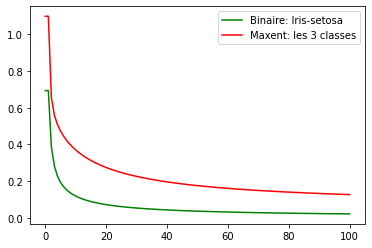

In [ ]:
maxent_iris = MaxEnt()
maxent_iris.entrainer(X_iris_train, Y_iris_onehot_train)


# Display of the evolution of the costs 
plt.plot(reg_iris_setosa.couts, color="green", label="Binaire: Iris-setosa")
plt.plot(maxent_iris.couts, color="red", label="Maxent: les 3 classes")
plt.legend()
plt.show()

**Note**: We notice that the convergence of the binary model is faster than that of the multiple logistics, and that the binary model gives a smaller error rate!

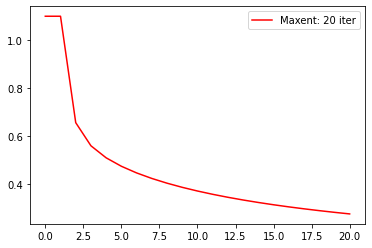

In [ ]:
# We train a Maxent model without letting it converge
# number of iterations 20
maxent20_iris = MaxEnt(nbr_iter=20)
maxent20_iris.entrainer(X_iris_train, Y_iris_onehot_train)


#Displaying the evolution of the costs 
plt.plot(maxent20_iris.couts, color="red", label="Maxent: 20 iter")
plt.legend()
plt.show()

### 2.3- Test and compare the two solutions 




In [ ]:
# Probability prediction with the three binary models
#model 1
iris_setosa_prob = reg_iris_setosa.predire(X_iris_test)
#model 2
iris_versicolor_prob = reg_iris_versicolor.predire(X_iris_test)
#model 3
iris_virginica_prob = reg_iris_virginica.predire(X_iris_test)

# merge the probabilities into a matrix
iris_modeles3_prob = np.column_stack((iris_setosa_prob, iris_versicolor_prob, iris_virginica_prob))

# encoding of outputs in 1, 2, 3
iris_modeles3_test = np.argmax(iris_modeles3_prob, axis=1) + 1

iris_modeles3_test

array([2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2])

In [ ]:
# Prediction of probabilities with the multinomial model
iris_maxent_prob = maxent_iris.predire(X_iris_test)

# encoding of the outputs in 1, 2, 3
iris_maxent_test = np.argmax(iris_maxent_prob, axis=1) + 1

iris_maxent_test

array([2, 1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 3, 1, 2, 3, 2, 3, 1, 1, 2, 3, 2])

In [ ]:
# Prediction of probabilities with the multinomial model with 5 iterations
iris_maxent20_prob = maxent20_iris.predire(X_iris_test)

# encoding of the outputs in 1, 2, 3
iris_maxent20_test = np.argmax(iris_maxent20_prob, axis=1) + 1

iris_maxent20_test

array([2, 1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 3, 1, 2, 3, 2, 3, 1, 1, 2, 3, 2])

In [ ]:
from sklearn.metrics import classification_report
class_names = ["setosa", "versicolor", "virginica"]

# By 3 models
print("Using 3 binary regression models")
print(classification_report(Y_iris_test, iris_modeles3_test, target_names=class_names))

# By 1 multinomial model
print("Using 1 multinomial regression model")
print(classification_report(Y_iris_test, iris_maxent_test, target_names=class_names))

# By 1 multinomial model (20 iterations)
print("Using 1 multinomial regression model (20 iterations)")
print(classification_report(Y_iris_test, iris_maxent20_test, target_names=class_names))

# Ignore the Warning at the bottom

Using 3 binary regression models
              precision    recall  f1-score   support

      setosa       0.88      1.00      0.93         7
  versicolor       0.64      0.90      0.75        10
   virginica       0.00      0.00      0.00         5

    accuracy                           0.73        22
   macro avg       0.51      0.63      0.56        22
weighted avg       0.57      0.73      0.64        22

Using 1 multinomial regression model
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         7
  versicolor       1.00      0.80      0.89        10
   virginica       0.71      1.00      0.83         5

    accuracy                           0.91        22
   macro avg       0.90      0.93      0.91        22
weighted avg       0.94      0.91      0.91        22

Using 1 multinomial regression model (20 iterations)
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         7
  vers

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Note** :   


**3 binary regression models Accuracy** 62% **Convergence** Slow  
**Multinomial regression model** **Accuracy** 94 **Convergence** Fast